In [19]:
%matplotlib inline
%pylab inline
import pandas as pd
import numpy as np
import io
import matplotlib
import matplotlib.pylab
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### TODO:
### 1. E.ON - check transactions (i.e. df[spend_rows & eon]  - is "E\.ON" finding it???) 
### 2. create constants for the column names
### 3. rename column names to category names (i.e. income_columns -> income_categories)


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Column/Category constants

DATE = 'Date'
DESCRIPTION = 'Description'
VALUE = 'Value'
TYPE = 'Type'
CATEGORY = 'Category'

INCOME_AISTEMOS = 'income_aistemos'
INCOME_SAVINGS  = 'income_savings'
INCOME_OTHER    = 'income_other'

SPEND_RENT      = 'spend_rent'
SPEND_UTILITIES = 'spend_utilities'
SPEND_FOOD      = 'spend_food'
SPEND_LUNCH     = 'spend_lunch'
SPEND_OTHER     = 'spend_other'

INCOME_COLUMNS = [INCOME_AISTEMOS, INCOME_SAVINGS, INCOME_OTHER]
NON_SAVINGS_INCOME_COLUMNS = [INCOME_AISTEMOS, INCOME_OTHER]
SPEND_COLUMNS  = [SPEND_RENT, SPEND_UTILITIES, SPEND_FOOD, SPEND_LUNCH, SPEND_OTHER]

In [3]:
# Read in data
df = pd.read_csv("data/all.csv", skipinitialspace=True, index_col=False, parse_dates=[0], dayfirst=True)

In [4]:
# Set index (useful for transforms later?). Index value does not need to be unique!
df.set_index(df['Date'],inplace=True)

In [5]:
# Fill in empty values
df['Description'].fillna('', inplace=True)
df['Value'].fillna(0, inplace=True)

In [6]:
# Drop columns we are not interested in
df.drop(['Balance', 'Account Name', 'Account Number'], axis=1, inplace=True)

In [7]:
# Select certain rows
income_rows = df['Value'] > 0
spend_rows = df['Value'] <= 0

# Income
income_aistemos_rows = income_rows & df['Description'].str.contains('AISTEMOS')
income_savings_rows  = income_rows & df['Description'].str.contains('FROM A/C 62638815')
income_other_rows    = income_rows & -(income_aistemos_rows | income_savings_rows)

# Spend: rent
chetwynd = df['Description'].str.upper().str.contains('BURGHLEYS')
bramshill = df['Description'].str.upper().str.contains('DUKE AND HERZOG')
spend_rent_rows = spend_rows & (chetwynd | bramshill)

# Spend: utilities
npower               = df['Description'].str.upper().str.contains('NPOWER')
eon                  = df['Description'].str.upper().str.contains('E\.ON')
virgin               = df['Description'].str.upper().str.contains('VIRGIN MEDIA')
o2                   = (df['Type'] =='D/D') & df['Description'].str.upper().str.contains('O2')
council              = (df['Type'] =='D/D') & df['Description'].str.upper().str.contains('L B CAMDEN')
water                = df['Description'].str.upper().str.contains('THAMES WATER')
tube_pass            = df['Description'].str.upper().str.contains('TFL TRAVEL')
travel_card          = df['Description'].str.upper().str.contains('LUL TICKET MACHINE')
gym                  = df['Description'].str.upper().str.contains('MAX FITNESS LTD')
rob                  = df['Description'].str.upper().str.contains('ROB WEISS')
spend_utilities_rows = spend_rows & (npower | virgin | o2 | council | water | tube_pass | travel_card | gym | rob)

# Spend: food
sainsbury       = spend_rows & df['Description'].str.upper().str.contains('SAINSBURY')
tesco           = spend_rows & df['Description'].str.upper().str.contains('TESCO')
spend_food_rows = spend_rows & (sainsbury | tesco)

# Spend: lunch
pret             = df['Description'].str.upper().str.contains('PRET A MANGER')
spend_lunch_rows = spend_rows & pret 

# Spend: other
spend_other_rows = spend_rows & -(spend_rent_rows | spend_utilities_rows | spend_food_rows | spend_lunch_rows)

In [8]:
# Add default Categories
df.loc[income_rows, CATEGORY] = INCOME_OTHER
df.loc[spend_rows, CATEGORY] = SPEND_OTHER

# Add specific Categories
df.loc[income_aistemos_rows, CATEGORY] = INCOME_AISTEMOS
df.loc[income_savings_rows, CATEGORY] = INCOME_SAVINGS
df.loc[spend_rent_rows, CATEGORY] = SPEND_RENT
df.loc[spend_utilities_rows, CATEGORY] = SPEND_UTILITIES
df.loc[spend_food_rows, CATEGORY] = SPEND_FOOD
df.loc[spend_lunch_rows, CATEGORY] = SPEND_LUNCH

# Convert Category column to type category
df[CATEGORY] = df[CATEGORY].astype('category')
df[0:5]

,Date,Type,Description,Value,Category
Date,,,,,
2015-01-02,2015-01-02,S/O,"'SAVE THE CHILDREN , FP 02/01/15 30 , 61023738...",-3.00,spend_other
2015-01-05,2015-01-05,POS,"'3289 31DEC14 , JUMBO PALERMO-VISA, CR5 , PALE...",-100.25,spend_other
2015-01-05,2015-01-05,POS,"'3289 02JAN15 C , M AND S SIMPLY FOOD - , SSP ...",-6.65,spend_other
2015-01-05,2015-01-05,POS,"'3289 02JAN15 , SAINSBURYS S/MKTS , FOTRESS RO...",-21.55,spend_food
2015-01-05,2015-01-05,POS,"'3289 02JAN15 C , TFL.GOV.UK/CP , TFL TRAVEL C...",-5.10,spend_utilities


In [9]:
# Group by (month, category)
df_per_month = df.groupby([pd.TimeGrouper('M'), CATEGORY]).sum().unstack()

# Convert missing values to 0
df_per_month.fillna(0, inplace=True)

# format as ints
df_per_month = df_per_month.astype(int)

print(df_per_month)

                     Value                                                                                          
Category   income_aistemos income_other income_savings spend_food spend_lunch spend_other spend_rent spend_utilities
Date                                                                                                                
2015-01-31            3398           17              0       -201         -15       -1573      -1516            -270
2015-02-28            3398           34            500       -117         -23       -1448      -1516            -825
2015-03-31            3398            0            700       -195         -67       -1971      -1516            -643
2015-04-30            3414            0              0       -127         -43       -1101      -1516            -608
2015-05-31            3414            0            200       -374         -35       -1113      -1516            -614
2015-06-30            3414            1              0       -24

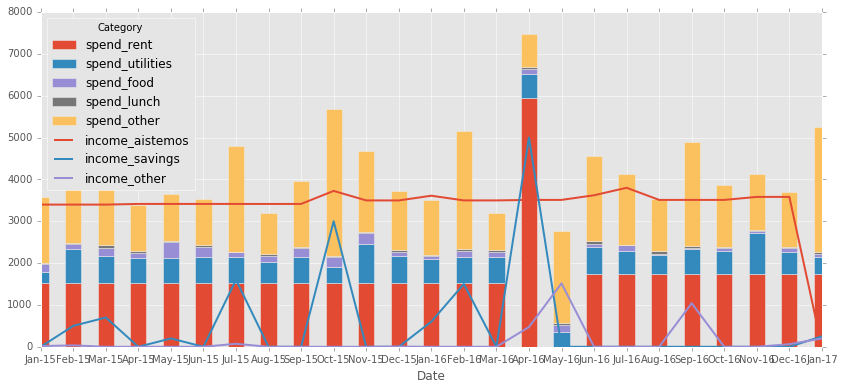

In [20]:
# Nicely formatted dates
dates_formatted = df_per_month.index.format(formatter=lambda x: x.strftime('%b-%y'))

# Seperate DataFrames for incomes/spend 
income_per_month = df_per_month[VALUE][INCOME_COLUMNS]
spend_per_month  = df_per_month[VALUE][SPEND_COLUMNS].abs()
                                                          
# For some reason, pandas needs explicit xs, otherwise does not plot two charts on same axes
income_per_month['Date'] = dates_formatted
spend_per_month['Date'] = dates_formatted

# Plot spends as columns, incomes as lines
ax = spend_per_month.plot(x='Date', kind='bar', stacked=True)
income_per_month.plot(ax=ax, x='Date', kind='line', linewidth=2)
plt.show()

In [11]:
# Totals for the entire time period
print(df.groupby(CATEGORY).sum().astype('int'))

                 Value
Category              
income_aistemos  84147
income_other      3425
income_savings   13350
spend_food       -3402
spend_lunch      -1047
spend_other     -42805
spend_rent      -42566
spend_utilities -14910


In [12]:
# Totals for the entire timeraneg of the data
total_income = df[df[CATEGORY].isin(INCOME_COLUMNS)].sum()
total_spend = df[df[CATEGORY].isin(SPEND_COLUMNS)].sum()

pd.DataFrame({'income': total_income, 'spend': total_spend}).astype('int')


,income,spend
Value,100923,-104732


In [13]:
# Top spends across the whole time period (excluding rent)
df[-spend_rent_rows].sort_values(by=VALUE)[0:10]


,Date,Type,Description,Value,Category
Date,,,,,
2017-01-10,2017-01-10,POS,"'3289 08JAN17 , A1 SERVICES , 02031376990 GB",-1677.63,spend_other
2015-10-26,2015-10-26,POS,"'3289 25OCT15 , BRITISH A , 125CD40871 , LONDO...",-1447.56,spend_other
2015-10-29,2015-10-29,POS,"'3289 25OCT15 , AZ WEB REGN , 0552323030 , AZ ...",-1236.81,spend_other
2016-02-01,2016-02-01,DPC,"'MISS MARIANA SAUL , BEN IMMANUEL , VIA MOBILE...",-1050.00,spend_other
2016-09-08,2016-09-08,POS,"'3289 06SEP16 , HMRC SELF , ASSESSMENT , CUMBE...",-998.60,spend_other
2016-07-22,2016-07-22,DPC,"'ASVSH ACCOUNTING , DEPOSIT , VIA MOBILE - PYM...",-700.00,spend_other
2015-11-03,2015-11-03,DPC,"'MISS MARIANA SAUL , BEN IMMANUEL , VIA MOBILE...",-600.00,spend_other
2015-09-10,2015-09-10,DPC,"'CALL REF.NO. 0239 , ANSAR LONDON LTD , FP 10/...",-600.00,spend_other
2016-01-20,2016-01-20,POS,"'3289 19JAN16 , APPLE STORE R245 , LONDON GB",-564.00,spend_other


In [14]:
### TEMP CHECKING CODE

# All rent transactions in April
df[spend_rent_rows & (df.index.month == 4) & (df.index.year == 2016)]

# All other transactions in April
df[spend_other_rows & (df.index.month == 4) & (df.index.year == 2016)]

# All other transactions in May
df[spend_other_rows & (df.index.month == 5) & (df.index.year == 2016)]

# All EON transactions (TODO: what is there description???)
df[spend_rows & eon]


,Date,Type,Description,Value,Category
Date,,,,,
2016-06-01,2016-06-01,D/D,'E.ON,-94.0,spend_other
2016-07-01,2016-07-01,D/D,'E.ON,-94.0,spend_other
2016-08-01,2016-08-01,D/D,'E.ON,-94.0,spend_other
2016-09-01,2016-09-01,D/D,'E.ON,-94.0,spend_other
2016-10-03,2016-10-03,D/D,'E.ON,-94.0,spend_other
2016-11-01,2016-11-01,D/D,'E.ON,-94.0,spend_other
2016-12-01,2016-12-01,D/D,'E.ON,-94.0,spend_other
2017-01-03,2017-01-03,D/D,'E.ON,-94.0,spend_other


In [15]:
# biggest "other" spends per month
with pd.option_context('display.max_rows', None):
    grouped = df[df[CATEGORY] == SPEND_OTHER].groupby(pd.TimeGrouper('M'))
    print(grouped[DATE, DESCRIPTION, VALUE].apply(lambda x: x.sort_values(by=[VALUE]).head(10)))

                            Date                                        Description    Value
Date       Date                                                                             
2015-01-31 2015-01-14 2015-01-14       '3289 13JAN15 , APPLE STORE R092 , LONDON GB  -539.00
           2015-01-14 2015-01-14      '3289 13JAN15 , WESTKIN ASSOCIATES, LONDON GB  -150.00
           2015-01-06 2015-01-06  '3289 05JAN15 , LUL TICKET OFFICE., TUFNELL PA...  -123.30
           2015-01-05 2015-01-05  '3289 31DEC14 , JUMBO PALERMO-VISA, CR5 , PALE...  -100.25
           2015-01-19 2015-01-19      '3289 16JAN15 , LURE FISH KITCHEN , LONDON GB   -41.63
           2015-01-12 2015-01-12             '3289 10JAN15 , BENTO CAFE , LONDON GB   -41.10
           2015-01-30 2015-01-30    '3289 29JAN15 , WAITROSE 112 , HOLLOWAY ROAD GB   -34.52
           2015-01-07 2015-01-07  '3289 06JAN15 , EB FRANK MCCOMB , LIVE , 0800-...   -33.30
           2015-01-05 2015-01-05                                      

In [16]:
# other spends in July 2015 (Holiday in Lisbon)
other_july_2015 = df[(df[CATEGORY] == SPEND_OTHER) & (df.index.month == 7) & (df.index.year == 2015)].copy()

other_july_2015.sort_values(by=[VALUE], inplace=True)

other_july_2015['cumulative'] = other_july_2015[VALUE].cumsum()

with pd.option_context('display.max_rows', None, 'display.max_colwidth', 50):
    print(other_july_2015[[DESCRIPTION, VALUE, 'cumulative']])
    

                                                  Description   Value  cumulative
Date                                                                             
2015-07-02  '3289 01JUL15 , BRITISH A , 125CD36673 , LONDO... -559.11     -559.11
2015-07-16  'MISS MARIANA SAUL , BEN IMMANUEL , VIA MOBILE... -200.00     -759.11
2015-07-03  '3289 02JUL15 , EASYJET , 000EPBT11Z , LUTON, ... -124.58     -883.69
2015-07-15  '3289 14JUL15 , R.PORTAS.S.ANTAO , LISBOA PT ,... -111.90     -995.59
2015-07-22  'MISS MARIANA SAUL , BEN IMMANUEL , VIA MOBILE... -100.00    -1095.59
2015-07-01             '3289 30JUN15 , AIRBNB , AIRBNB.COM GB  -82.00    -1177.59
2015-07-13  '3289 11JUL15 , PC MARQUES POMBAL,, 16 , LISBO...  -76.11    -1253.70
2015-07-13  '3289 10JUL15 , R CARDEAL , MERCIER,2/4 , LISB...  -76.11    -1329.81
2015-07-02  '3289 01JUL15 , AEROPORTO , LISBOA-CHEGA , LIS...  -75.24    -1405.05
2015-07-06  '3289 03JUL15 , R DO COMERCIO, , 95-119 , LISB...  -75.15    -1480.20
2015-07-06  '328

In [17]:
# Typical utilities spend

utils_typical = df[(df[CATEGORY] == SPEND_UTILITIES) & (df.index.month == 9) & (df.index.year == 2015)]

utils_typical = utils_typical.sort_values(by=VALUE)

utils_typical['cumulative'] = utils_typical[VALUE].cumsum()

utils_typical['percent'] = utils_typical[VALUE] / utils_typical[VALUE].sum()

utils_typical[[DESCRIPTION, VALUE, 'cumulative', 'percent']]


,Description,Value,cumulative,percent
Date,,,,
2015-09-08,"'ROB WEISS , 1408-20 BEN , VIA MOBILE - PYMT ,...",-240.00,-240.00,0.378274
2015-09-25,"'3289 24SEP15 , LUL TICKET MACHINE, KENTISH TO...",-123.30,-363.30,0.194338
2015-09-07,'L B CAMDEN,-84.00,-447.30,0.132396
2015-09-07,'NPOWER,-52.00,-499.30,0.081959
2015-09-07,'NPOWER,-51.00,-550.30,0.080383
2015-09-14,'VIRGIN MEDIA PYMTS,-31.25,-581.55,0.049254
2015-09-14,'THAMES WATER,-25.00,-606.55,0.039404
2015-09-28,'O2,-20.61,-627.16,0.032484
2015-09-01,"'3289 30AUG15 , LUL TICKET MACHINE, HAMMERSMIT...",-5.00,-632.16,0.007881
